In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.70517814,  0.70903015, -0.1703155 ], dtype=float32)

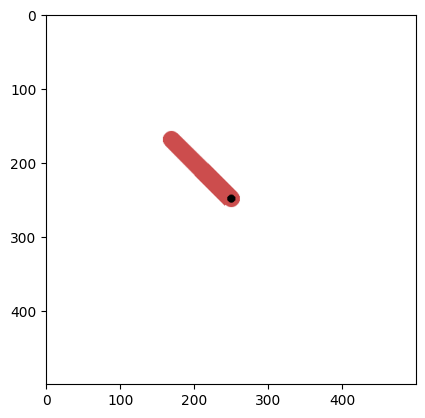

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        return self.sequential(state) * 2.0


model_action = Model()
model_action_next = Model()

model_action_next.load_state_dict(model_action.state_dict())

model_action(torch.randn(1, 3))

tensor([[0.3569]], grad_fn=<MulBackward0>)

In [4]:
model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(1, 4))

tensor([[-0.0948]], grad_fn=<AddmmBackward0>)

In [5]:
import random
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model_action(state).item()
    #给动作添加噪声,增加探索
    action += random.normalvariate(mu=0, sigma=0.01)
    return action


get_action([1, 2, 3])

0.3161582674136165

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step([action])

        #记录数据样本
        datas.append((state, action, reward, next_state, over))

        #更新游戏状态,开始下一个动作
        state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)


update_data()

len(datas), datas[0]

(200,
 (array([ 0.99298847, -0.11821105, -0.09574469], dtype=float32),
  0.44153784519818506,
  -0.015151092194003398,
  array([ 0.9922727 , -0.12407614, -0.1181723 ], dtype=float32),
  False))

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_2036/1710091499.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[ 0.1469, -0.9891,  1.7092],
         [ 0.9923, -0.1241, -0.1182],
         [-0.9136,  0.4065,  5.6514],
         [-0.9862, -0.1656, -5.9019],
         [-0.0980, -0.9952, -3.6718]]),
 tensor([[0.4019],
         [0.4501],
         [0.5536],
         [1.0190],
         [0.8703]]),
 tensor([[ -2.3182],
         [ -0.0171],
         [-10.6085],
         [-12.3365],
         [ -4.1344]]),
 tensor([[ 0.1976, -0.9803,  1.0277],
         [ 0.9914, -0.1312, -0.1437],
         [-0.9932,  0.1164,  6.0393],
         [-0.9919,  0.1270, -5.8732],
         [-0.3075, -0.9516, -4.2876]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1208.2554823965668

In [9]:
def get_value(state, action):
    #直接评估综合了state和action的value
    #[b, 3+1] -> [b, 4]
    input = torch.cat([state, action], dim=1)

    #[b, 4] -> [b, 1]
    return model_value(input)


def get_target(next_state, reward, over):
    #对next_state的评估需要先把它对应的动作计算出来,这里用model_action_next来计算
    #[b, 3] -> [b, 1]
    action = model_action_next(next_state)

    #和value的计算一样,action拼合进next_state里综合计算
    #[b, 3+1] -> [b, 4]
    input = torch.cat([next_state, action], dim=1)

    #[b, 4] -> [b, 1]
    target = model_value_next(input) * 0.98

    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_value(state, action)[:5], get_target(next_state, reward, over)[:5]

(tensor([[ 0.1190],
         [ 0.0410],
         [ 0.3272],
         [-0.2255],
         [-0.1502]], grad_fn=<SliceBackward0>),
 tensor([[ -2.2370],
         [  0.0221],
         [-10.2570],
         [-12.5429],
         [ -4.3034]], grad_fn=<SliceBackward0>))

In [10]:
def get_loss_action(state):
    #首先把动作计算出来
    #[b, 3] -> [b, 1]
    action = model_action(state)

    #像value计算那里一样,拼合state和action综合计算
    #[b, 3+1] -> [b, 4]
    input = torch.cat([state, action], dim=1)

    #使用value网络评估动作的价值,价值是越高越好
    #因为这里是在计算loss,loss是越小越好,所以符号取反
    #[b, 4] -> [b, 1] -> [1]
    loss = -model_value(input).mean()

    return loss


get_loss_action(state)

tensor(-0.0231, grad_fn=<NegBackward0>)

In [11]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [12]:
def train():
    model_action.train()
    model_value.train()
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
    optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算value和target
            value = get_value(state, action)
            target = get_target(next_state, reward, over)

            #两者求差,计算loss,更新参数
            loss_value = loss_fn(value, target)

            optimizer_value.zero_grad()
            loss_value.backward()
            optimizer_value.step()

            #使用value网络评估action网络的loss,更新参数
            loss_action = get_loss_action(state)

            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #以一个小的比例更新
            soft_update(model_action, model_action_next)
            soft_update(model_value, model_value_next)

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), test_result)


train()

0 400 -1481.9745946129065
20 4400 -446.2614963239106
40 8400 -165.38135583027767
60 10000 -175.05355035907678
80 10000 -176.24764820731824
100 10000 -171.3202831257185
120 10000 -137.3814099448686
140 10000 -182.0192419057948
160 10000 -93.50676630591069
180 10000 -100.80603271275491


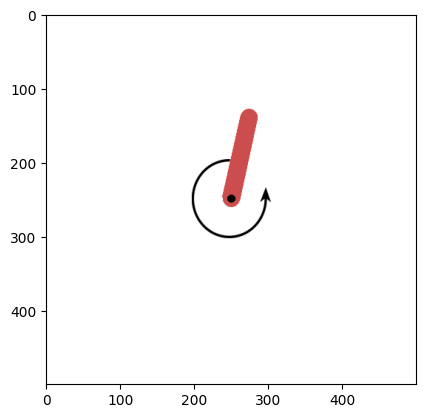

-129.54026289274628

In [13]:
test(play=True)